In [1]:
!export CUDA_VISIBLE_DEVICES=0

import torch, json
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from copy import deepcopy
from plotly.offline import init_notebook_mode

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from vae_dist.data.visualize import plot_vfield
from vae_dist.dataset.dataset import FieldDataset
from vae_dist.data.visualize import get_latent_space
from vae_dist.core.training_utils import construct_model 

init_notebook_mode(connected=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/santiagovargas/anaconda3/envs/bondnet_e3nn/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/santiagovargas/anaconda3/envs/bondnet_e3nn/lib/python3.7/site-packages/requests/__init__.py:104: RequestsDependencyWarning:

urllib3 (1.26.11) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!



In [3]:
model_list = []
model_names = "model_single_datapoint.ckpt"

for model_type in ['cnn', 'vae']:
    options = json.load(open('./options/options_{}_default.json'.format(model_type)))
    model_temp = construct_model(model_type, options)
    model_temp.load_model("./logs/log_version_{}_1/{}".format(model_type, model_names))
    model_temp.to(device)
    model_temp.eval()
    model_list.append(deepcopy(model_temp))


model_untrained = construct_model(model_type, options)
model_untrained.to(device)
model_untrained.eval()    

inner_dim:  3
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 18, 18, 18]           6,176
         LeakyReLU-2       [-1, 32, 18, 18, 18]               0
       BatchNorm3d-3       [-1, 32, 18, 18, 18]              64
         ConvBatch-4       [-1, 32, 18, 18, 18]               0
            Conv3d-5       [-1, 64, 16, 16, 16]          55,360
         LeakyReLU-6       [-1, 64, 16, 16, 16]               0
       BatchNorm3d-7       [-1, 64, 16, 16, 16]             128
         ConvBatch-8       [-1, 64, 16, 16, 16]               0
            Conv3d-9      [-1, 128, 14, 14, 14]         221,312
        LeakyReLU-10      [-1, 128, 14, 14, 14]               0
      BatchNorm3d-11      [-1, 128, 14, 14, 14]             256
        ConvBatch-12      [-1, 128, 14, 14, 14]               0
        MaxPool3d-13         [-1, 128, 7, 7, 7]               0
           Conv3d-14     

baselineVAEAutoencoder(
  (fc_mu): Linear(in_features=50, out_features=1, bias=True)
  (fc_var): Linear(in_features=50, out_features=1, bias=True)
  (encoder_conv): Sequential(
    (0): ConvBatch(
      (conv): Sequential(
        (0): Conv3d(3, 32, kernel_size=(4, 4, 4), stride=(1, 1, 1), bias=False)
        (1): LeakyReLU(negative_slope=0.2)
        (2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ConvBatch(
      (conv): Sequential(
        (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
        (1): LeakyReLU(negative_slope=0.2)
        (2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): ConvBatch(
      (conv): Sequential(
        (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
        (1): LeakyReLU(negative_slope=0.2)
        (2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [5]:
root = "../../data/cpet_augmented/"

dataset_single = FieldDataset(
        root, 
        transform=False, 
        augmentation=False,
        standardize=False,
        lower_filter=True,
        log_scale=True, 
        min_max_scale=True,
        wrangle_outliers=False,
        scalar=False,
        device=device
    )

dataset_loader_full = torch.utils.data.DataLoader(
                dataset_single, 
                batch_size=1,
                shuffle=True,
                num_workers=0
            )

Data shape:  (1674, 3, 21, 21, 21)
Data type:  float64
------------------------- Preprocessing Info -------------------------
Helmholtz-Hodge decomposition applied:  False
Lower filter applied:  True
Log scale applied:  True
Standardization applied:  False
Min max scaling applied:  True
Wrangling outliers applied:  False
------------------------- Data Info -------------------------
Mean value in dataset:  -7.990476285082057e-05
Standard deviation in dataset:  0.03374411730139573
Largest value in dataset:  1.0
Smallest value in dataset:  -1.0
Nan values in dataset:  False
Inf values in dataset:  False


Aug
Total number of fields:  1674
Aug
Total number of fields:  1674
Aug


IndexError: list index out of range

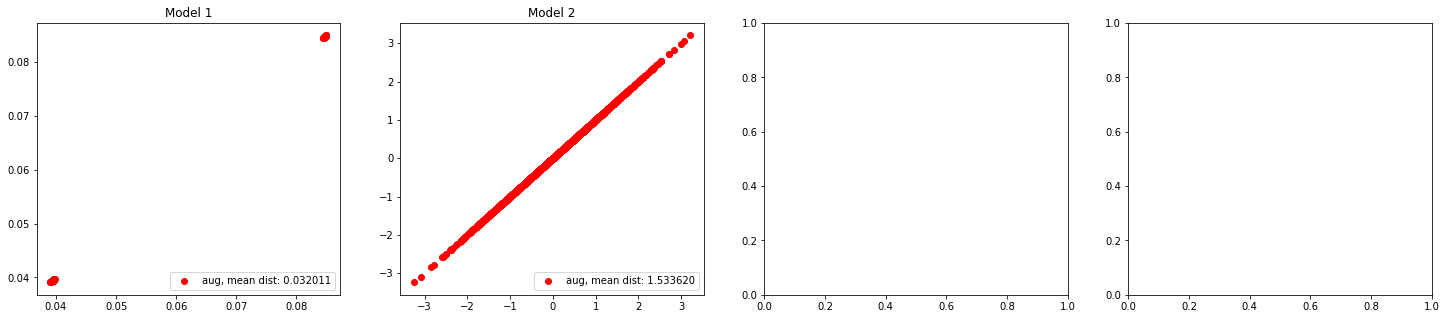

In [7]:
def mean_distance(latent_space):
    mean_dist = 0
    for i in range(latent_space.shape[0]):
        for j in range(latent_space.shape[0]):
            mean_dist += np.linalg.norm(latent_space[i] - latent_space[j])
    mean_dist /= latent_space.shape[0]**2
    return mean_dist


fig, axs = plt.subplots(1, 4, figsize=(25, 5))
# iterate over the sub plots
for i, ax in enumerate(axs.flatten()):
    # plot the data
    print("Aug")
    latent_space_aug = get_latent_space(model_list[i], dataset_single, comp=[0, 0], latent_dim=1)
    mean_aug = mean_distance(latent_space_aug)

    ax.scatter(
        latent_space_aug[:, 0], 
        latent_space_aug[:, 1], c="red", 
        label="aug, mean dist: {:.6f}".format(mean_aug))

    # legend bottom right
    ax.legend(loc="lower right")
    ax.set_title(f"Model {i+1}")

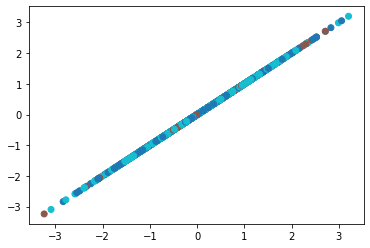

In [41]:
def scatter_plot_color_by_class(latent_space, labels):
    
    plt.scatter(
        latent_space[:, 0], 
        latent_space[:, 1], 
        c=labels, 
        cmap="tab10"
    )

    

def pull_labels(
    names, dir_data="../../../data/protein_data.csv"
):
    # iterate through names 
    # pull labels from csv file
    # return list of labels
    labels = []
    df = pd.read_csv(dir_data)
    for name in names:
        for row in df.iterrows():
            if name == row[1]["name"]:
                labels.append(row[1]["label"])
    return labels


list_name = dataset_single.names
raw_names = [name.split("_")[2] for name in list_name]
labels = pull_labels(raw_names, dir_data="../../data/protein_data.csv")
# convert labels to colors where H = red Y = blue and C = green
labels = [0 if label == "H" else 1 if label == "Y" else 2 for label in labels]
scatter_plot_color_by_class(latent_space_aug, labels)


In [23]:
def show_in_out_plots(in_field, model):
    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{'type': 'cone'}, {'type': 'cone'}]])

    model = model_list[0]
    x = in_field.reshape(1, 3, 21, 21, 21).to(device)
    x_out = model.forward(x)
    x_out = x_out.to('cpu').detach().numpy().reshape(1, 3, 21, 21, 21)

    field_in, comp_in  = plot_vfield(
            x.cpu().numpy(), 
            cutoff_low = 85, 
            cutoff_high=100, 
            min_max = False,
            scale = 2)
    field_out, comp_out = plot_vfield(
            x_out, 
            cutoff_low = 85, 
            cutoff_high=100, 
            min_max = False,
            scale = 2)

    # add field_in to the first subplot
    fig.add_trace(field_in , row=1, col=1)
    # add field_out to the second subplot
    fig.add_trace(field_out, row=1, col=2)

    fig.update_layout(
            scene = dict(
                xaxis = dict(nticks=10, range=[-3,3],),
                yaxis = dict(nticks=10, range=[-3,3],),
                zaxis = dict(nticks=10, range=[-3,3],)),
            scene2 = dict(
                xaxis = dict(nticks=10, range=[-3,3],),
                yaxis = dict(nticks=10, range=[-3,3],),
                zaxis = dict(nticks=10, range=[-3,3],)),
            title='Slices in volumetric data',
            width=1000, height=600)

    fig.show()
    return comp_in, comp_out
# this is raw field data
test_field = dataset_single.dataraw[0].reshape(1, 3, 21, 21, 21)
# this is the field data after the preprocessing
test_field = dataset_single[0].reshape(1, 3, 21, 21, 21)
#make test field  a tensor
test_field = test_field.clone().detach()
test_field = test_field.to(device, dtype=torch.float)
comp_in, comp_out = show_in_out_plots(test_field, model_list[0])
#comp_in, comp_out = show_in_out_plots(test_field, model_untrained)


-0.47 0.34
-0.03834631 0.067888804


In [31]:
# compute rmse between comp in and out 
def rmse(comp_in, comp_out):
    rmse = 0
    # get the keys of the dictionary
    keys = list(comp_in.keys())
    dict_residuals = {}
    # iterate over the keys
    for key in keys:
        dict_residuals[key] = [np.array(comp_in[key]) - np.array(comp_out[key])]
        
    total_residuals = np.concatenate(list(dict_residuals.values()))
    print(total_residuals.shape)
    # compute l2 norm along the first axis
    norm = np.linalg.norm(total_residuals, axis=0)
    rmse = np.sqrt(np.mean(norm**2))
    print("RMSE: {:.6f}".format(rmse))
    print("MAE: {:.6f}".format(np.mean(norm)))
    
    return rmse

rmse(comp_in, comp_out)

(3, 9261)
RMSE: 0.042981
MAE: 0.019308


0.042980675